# Import Libraries

In [47]:
# Magic iPython command to enable plotting
%matplotlib inline

experiment='cxilv1118'
pullDataFromUser='sample' # update me to mrware or igablsk
RESULTSPATH=('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,pullDataFromUser)).strip()
# Load in the pythonBatchMagic library
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Load point data from pkl (preferred)

In [48]:
import os
import pickle
def load_obj(filename ):
    """
    Loads object from name.pkl and returns its value

    Args:
        filename: String designating directory and name of file, ie. /Folder/Filename, where Filename.pkl is the object

    Returns:
        The value of the object in filename
    """
    try:
        with open(filename + '.pkl', 'rb') as f:
            print filename+" remembered!"
            return pickle.load(f)
    except IOError as e:
        print "IOError: Did you load the correct file? %s" % filename
        raise e
        
def combineRuns(runNumbers, path=RESULTSPATH):
    detArrays = {}
    for idx,run in enumerate(runNumbers):
        if idx == 0:
            detArrays = load_obj(path+'/pointData-run-%d' % run)
        else:
            try:
                detArrays0 = load_obj(path+'/pointData-run-%d' % run)
                for key in detArrays.keys():
                    try:
                        detArrays[key] = np.append( detArrays[key], detArrays0[key], axis=0 )
                    except KeyError as ke:
                        print('Dropping key %s since it is not in %d' % (key,run))
                        detArrays.pop(key, None)
            except IOError as ioe:
                print(str(ioe))
                continue
    return detArrays

In [49]:
# runNumbers = [49]
runNumbers = [50,54]

# detArrays = combineRuns(runNumbers, path='/cds/data/psdm/cxi/cxilu9218/results/khegazy/')
detArrays = combineRuns(runNumbers)

/cds/data/psdm/cxi/cxilv1118/results/sample/pointData-run-50 remembered!
/cds/data/psdm/cxi/cxilv1118/results/sample/pointData-run-54 remembered!
Dropping key uvint0 since it is not in 54


## Load point data from npz
Path name will be updated to point to experimental directories and a specific run. 
Function will be added to combine runs.

Commented to prevent accidental execution.

In [50]:
# loadedFile = np.load('Bromomethane-FullUV.npz')
# detArrays = {}
# for key in loadedFile.keys():
#     detArrays[key] = loadedFile[key]
# loadedFile.close()

# Generate H5 file for matlab users


Commented to prevent accidental execution.

In [51]:
# import h5py
# try:
#     h5f.close()
# except NameError as ne:
#     if 'not defined' in str(ne):
#         pass
#     else:
#         raise ne
# h5f = h5py.File('Bromomethane-FullUV.h5', 'w')

# for akey in detArrays.keys():
#     h5f.create_dataset(akey, data=detArrays[akey])
# h5f.close()

# Q map

Text(0,0.5,'DQ between adjecent radiial bins (inv Ang)')

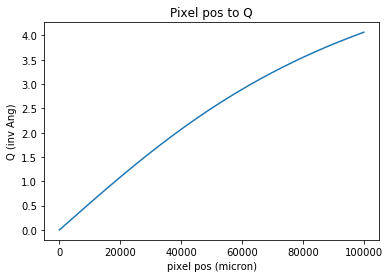

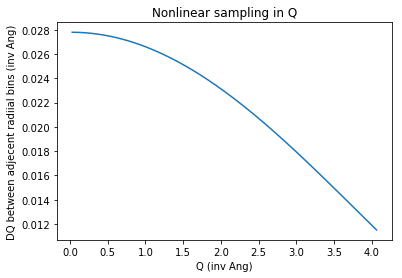

In [52]:
x = np.linspace(0,1e5,200)
L = 90.7*1000. # micron
TwoTheta = np.arctan(x/L)
lambdaX = 1.252
Q = 4*np.pi*np.sin(TwoTheta/2) / lambdaX
plt.figure()
plt.plot(x,Q)
plt.xlabel('pixel pos (micron)')
plt.ylabel('Q (inv Ang)')
plt.title('Pixel pos to Q')
plt.figure()
plt.title('Nonlinear sampling in Q')
plt.plot(Q[1:],np.diff(Q))
plt.xlabel('Q (inv Ang)')
plt.ylabel('DQ between adjecent radiial bins (inv Ang)')


# Radiial rois vs. pixel and vs. Q

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.10/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0,0.5,'mean adu')

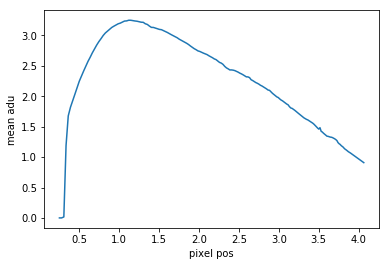

In [53]:
plt.figure()
meanSig = np.nanmean(detArrays['rois'][1:],0)
plt.plot(Q,Q*meanSig)
plt.xlabel('pixel pos')
plt.ylabel('mean adu')
# plt.xlim([0,0.5])

### Apply detector response function to the average scattering pattern and compare to the theoretical signal

In [58]:
def normalizedPlot(x,y,s=1,**kwargs):
    plt.plot(x, y/np.nanmax(y)*s,**kwargs)

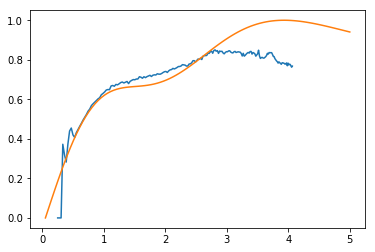

In [61]:
responseFunctionDict = np.load(RESULTSPATH+'/responseFunction.npz')
responseFunction = responseFunctionDict['responseFunction']
QrF = responseFunctionDict['Q']

interpolatedRF = np.interp(Q, QrF, responseFunction)

Mol = np.load('/cds/data/psdm/cxi/cxilv1118/results/referenceScripts/LV11-Examples/Molecular Geometries/CH3Br.npz')


normalizedPlot(Q,Q*interpolatedRF*meanSig,s=.85)
normalizedPlot(Mol['Q'],Mol['Q']*Mol['I'])

# Correlation between integrated xray scattering on Jungfrau and xray fluoresence diode in chamber
If this does not show a strong correlation, then the detector is likely recieving incorrect time stamps from the system (off by one) if you notice this, speak up!

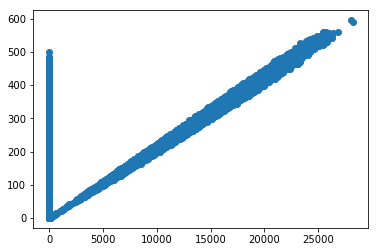

In [35]:
plt.scatter( detArrays['xint'], np.nansum(detArrays['rois'],-1) )

# Histogram of timetool pixel position
Values should be centered at 500. You may see two satellite fringes. The satellite fringes should be filtered from the data

75566


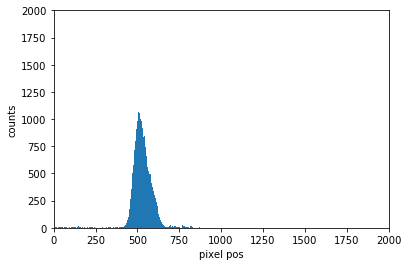

In [36]:
plt.hist(detArrays['ttfltpos'],2000);
print(np.sum(detArrays['ttfltpos']>0))
plt.xlim([0,2000])
plt.ylim([0,2e3])
plt.ylabel('counts');
plt.xlabel('pixel pos');

# Histogram of the FWHM of the fitted timetool edge
Values between ~50 and 150 are acceptable

Text(0.5,0,'edge width')

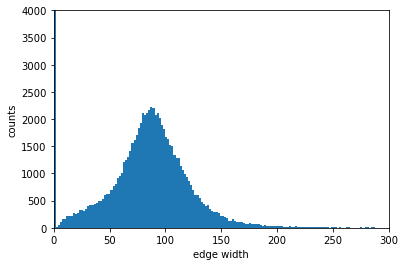

In [37]:
plt.hist(detArrays['ttfltposfwhm'],3000);
plt.xlim([0,300])
plt.ylim([0,4000])
plt.ylabel('counts')
plt.xlabel('edge width')

# Histogram of the amplitude of the timetool signal
Valuesabove ~0.01 are good

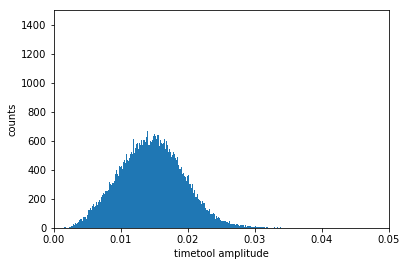

In [38]:
plt.hist(detArrays['ttfltposampl'],500,range=(0,.05));
plt.xlim([0,0.05])
plt.ylim([0,1500])
plt.ylabel('counts')
plt.xlabel('timetool amplitude');

# From seconds, nanoseconds, and fiducials generate the labtime

In [39]:
import datetime
import matplotlib.dates as dates
def getLabtime(second, microseconds):
    refdate = datetime.datetime(1970,1,1)
    td = datetime.timedelta(seconds=second,microseconds=microseconds)
    return refdate+td
labtime = np.array([getLabtime( s, float(ns)/1000. ) for s,ns in zip(detArrays['seconds'],detArrays['nanoseconds'])])

# Plot the sum of the Jungfrau normalized by the xray pulse energy over lab time
Changes in this distribution indicate changes in the scattering, i.e. pressure or deposition on the Berrylium window

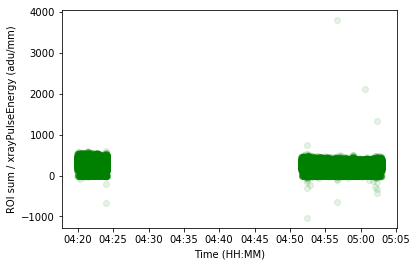

In [40]:
fig,ax= plt.subplots()
date_form = dates.DateFormatter('%H:%M', tz=None)

roiSum = np.nansum(detArrays['rois'][:,10:],-1)
xEng = detArrays['xrayEnergy']
goodIdx = (~np.isnan(roiSum))&(~np.isnan(xEng.astype(float)))
ratio = roiSum[goodIdx] / xEng[goodIdx]
ax.plot(labtime[goodIdx], ratio,'go',alpha=0.1)
# ax.set_ylim([0,4])
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Time (HH:MM)')
plt.ylabel('ROI sum / xrayPulseEnergy (adu/mm)');
# plt.ylim()

# Plot the ratio of radiial rois vs. lab time
Changes in this distribution indicate deposition on the Berrylium window or degradation of the sample, i.e. sample is not refreshing so fragments out number desired sample

In [19]:
fig,ax= plt.subplots()
date_form = dates.DateFormatter('%H:%M', tz=None)

roiSum1 = np.sum(detArrays['rois'][:,1:4],-1)
roiSum2 = np.sum(detArrays['rois'][:,4:7],-1)

goodIdx = (~np.isnan(roiSum1))&(~np.isnan(roiSum2.astype(float)))
ratio = roiSum1[goodIdx] / roiSum2[goodIdx]
ax.plot(labtime[goodIdx], ratio,'go',alpha=0.025)
ax.set_ylim([0,8])
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Time (HH:MM)')
plt.ylabel('ROI1 sum / ROI2 sum');

Error in callback <function post_execute at 0x7f64e1d4ad70> (for post_execute):


ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 432x288 with 1 Axes>

# Acquiris Channel 0, integrated diode
This is the UV power vs lab time

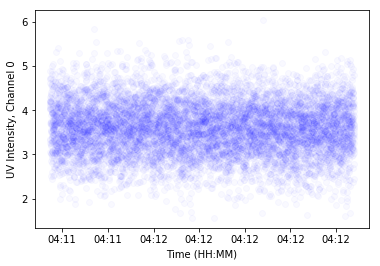

In [22]:
fig,ax= plt.subplots()
date_form = dates.DateFormatter('%H:%M', tz=None)
ax.plot(labtime, detArrays['uvint1'],'bo',alpha=0.025)
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Time (HH:MM)')
plt.ylabel('UV Intensity, Channel 0');

# Gas pressure vs lab time

Text(0.5,0,'Time (HH:MM)')

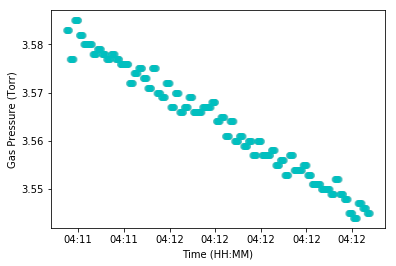

In [23]:
fig,ax= plt.subplots()
date_form = dates.DateFormatter('%H:%M', tz=None)
ax.plot(labtime, detArrays['gasPressure']-0.68,'co',alpha=0.025)
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('Gas Pressure (Torr)');
plt.xlabel('Time (HH:MM)')

# Determine the data acquisition rate from the time stamps

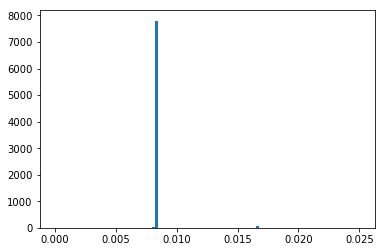

In [24]:
# dts = np.diff(labtime)
labtime_seconds = np.sort([(lt-datetime.datetime(1970,1,1)).total_seconds() for lt in labtime])
w=plt.hist(np.diff(labtime_seconds),bins=100,range=(0,.025));

In [25]:
weights = w[0]
edges = w[1][:-1]
idx = np.argmax(weights)
print( 'New shot every %f seconds' % edges[idx] )

New shot every 0.008250 seconds


# Histogram of gas pressures

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.10/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


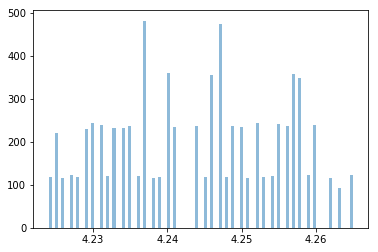

In [26]:
fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['gasPressure'], bins=100,normed=False, alpha=0.5);


# Histogram of pixel values on detector images (peaks indicate 1,2,3,... photon scattering events. Noninteger multiples are likely fluoresence. Speak up if you see noninteger multiples)

(7920, 200)
0.9334422816981918
12338.490656565657
52.80643939393939
12509.444444444443


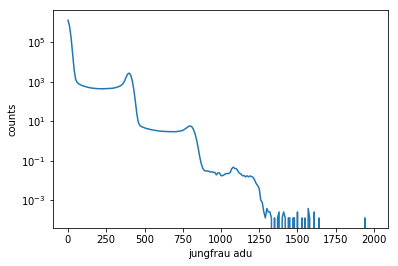

In [31]:
adu = np.arange(200) * 10
photonHistMean = np.nanmean(detArrays['photonHist'],0) 

plt.semilogy( adu,photonHistMean)
plt.xlabel('jungfrau adu')
plt.ylabel('counts')
print(detArrays['photonHist'].shape)

print( np.nanmean(detArrays['xrayEnergy'].astype(float)) )
print( np.sum( photonHistMean[ (adu>350)&(adu<450) ] ) )
print( np.sum( photonHistMean[ (adu>2*350)&(adu<2*450) ] ) )
print( np.sum( photonHistMean[adu>350] ) )

# Histogram of UV intensities

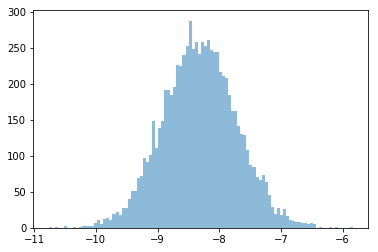

In [30]:
fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['uvint0'][~np.isnan(detArrays['uvint0'])], bins=100,normed=False, alpha=0.5);
# print(detArrays['xrayEnergy'].shape)
# plt.savefig('runfolder/hist-xrayenergy')

# Outlier rejection and time bining

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


127319
185600
('allidx', 185600)
('goodidx', 127319)
('offidx', 53860)


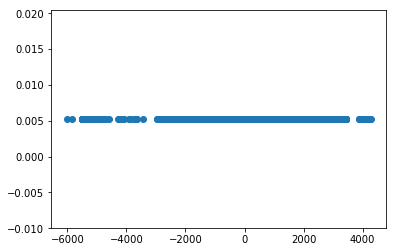

In [86]:
goodIdx = ( detArrays['xrayEnergy']>.3 ) & (np.nansum(detArrays['rois'],-1) > 20) & (~np.isnan(detArrays['uvint']))
offIdx = goodIdx &(~detArrays['laserOn'].astype(bool))
goodIdx = goodIdx & ( detArrays['laserOn'].astype(bool)) 
# goodIdx = goodIdx &( (detArrays['ttfltpos']>490)  & (detArrays['ttfltpos']<510)  )

dp=450
# dp=130
# dp=100
goodIdx = goodIdx &( (detArrays['ttfltpos']>500-dp)  & (detArrays['ttfltpos']<500+dp)  )
goodIdx = goodIdx &( (detArrays['ttfltposfwhm']>5) )
goodIdx = goodIdx &( (detArrays['ttfltposampl']>.005)   )

# goodIdx = detArrays['laserOn'].astype(bool) & ( detArrays['rois'][:,10] > 0 ).astype(bool) & (detArrays['xrayEnergy']>.1)
# offIdx = (~detArrays['laserOn'].astype(bool)) & ( detArrays['rois'][:,10] > 0 ).astype(bool) & (detArrays['xrayEnergy']>.1)



pos = detArrays['stageencoder'][goodIdx] 
ttpos = detArrays['ttfltpos'][goodIdx]
goodRois = detArrays['rois'][goodIdx,:]
offRois =  detArrays['rois'][offIdx,:]
# goodRois = (detArrays['rois'][goodIdx,:].T/detArrays['xdiode'][goodIdx].T).T
# offRois =  (detArrays['rois'][offIdx,:].T/detArrays['xdiode'][offIdx].T).T
print(np.sum(goodIdx>0))
print(detArrays['ttfltpos'].size)

ttpoly = [2.95684259e-06, -1.43969413e-03]
def ttcorr(ttpos,ttpoly):
    return ttpoly[0]*ttpos+ttpoly[1]
truepos = -2*(pos-56.35) / (3e-4)  - ttcorr(ttpos,ttpoly)*1.0e6
posfs = -2*(pos-56.35) / (3e-4) 

# print(goodRois.shape)
roi1 = np.nansum(goodRois, -1)
roio = np.nansum(offRois,-1)
plotMe = ((goodRois.T)/(roi1.T)).T
# print(plotMe.shape,pos.shape)
plt.scatter(truepos,  np.nanmean(plotMe[:,:],-1) );

print('allidx',detArrays['ttfltpos'].size)
print('goodidx',np.sum(goodIdx))
print('offidx',np.sum(offIdx))

# Histogram of the timetool positions after outlier rejection

Text(0,0.5,'counts')

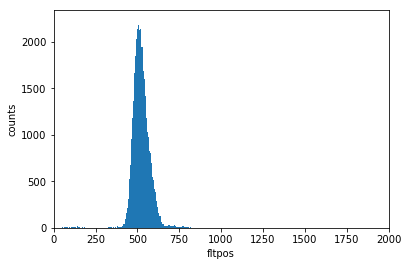

In [16]:
plt.hist(detArrays['ttfltpos'][goodIdx],500);
plt.xlim([0,2000])
plt.xlabel('fltpos')
plt.ylabel('counts')

# Plot the unique delays scanned

Text(0.5,0,'idx')

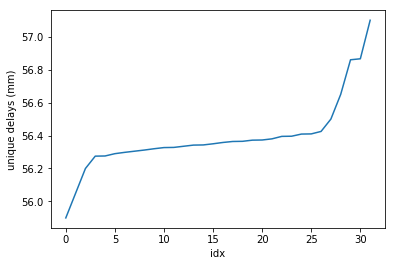

In [87]:
plt.plot(np.sort(np.unique( np.round(pos,decimals=3),axis=None)))
plt.ylabel('unique delays (mm)')
plt.xlabel('idx')

# Preprocess the radiall rois by normalizing by xray energy and subtracting the nearest off shot

In [108]:
# dtime = labtime-labtime[100]
# dtime_s = [dt.total_seconds() for dt in dtime]

def makeWeights( rois, goodIdx, offIdx, labtime ):
    offtime = labtime[offIdx]
    goodtime = labtime[goodIdx]
    offrois = rois[offIdx,:]
    goodrois = rois[goodIdx,:]
    
    osum = np.nansum(offrois,-1)
    offroiN = ((offrois.T)/(osum.T)).T
    gsum = np.nansum(goodrois,-1)
    groiN = ((goodrois.T)/(gsum.T)).T
    
    offDelta = offtime-datetime.datetime(1970,1,1)
    offDelta_s = np.array([dt.total_seconds() for dt in offDelta])
    offArg = np.argsort( offDelta_s )
    offMin = np.min(offDelta_s)
    offMax = np.max(offDelta_s)
    offRange = offMax-offMin
    noff = offtime.size
    
    offroiNS = offroiN[offArg,:]
    
    weights = np.zeros_like(goodrois)
    for idx,atime in enumerate(goodtime):
#         print(idx,goodtime.size)
        dtime =( atime-datetime.datetime(1970,1,1)).total_seconds()
        oidx = int((dtime - offMin)/offRange*noff)
        if oidx < 0:
            oidx = 0
        if oidx >= noff:
            oidx = noff-1
        weights[idx,:] = groiN[idx,:] - 0*offroiNS[oidx,:]
        
    return weights

In [109]:
weightMe = makeWeights( detArrays['rois'], goodIdx, offIdx, labtime )

# Rebin the shot-by-shot data into time bins (without timetool correction)

In [110]:
db = 1e-3
bins = np.unique(pos) - db
bins = np.append(bins, bins[-1]+ 2*db)
nb = bins.size
nr = goodRois.shape[1]

def createBinsFromCenters(centers):
    bins = []
    nc = centers.size
    for idx,c in enumerate(centers):
        if idx == 0:
            dc = np.abs( c - centers[idx])/2.
            bins.append(c-dc)
            bins.append(c+dc)
        elif idx == nc-1:
            dc = np.abs( c - centers[idx-1])/2.
            bins.append(c+dc)
        else:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c+dc)
#         print(dc)
    return np.array(bins)

def determineGoodCenters( pos ):
    upos = np.unique(pos)
    gpos = []
    for idx,up in enumerate(upos):
        c = np.sum(upos == up)
        if c>10:
            gpos.append()
        
bins = createBinsFromCenters(  np.sort(np.unique( np.round(pos,decimals=3),axis=None)).flatten())
binspos = bins
# print(bins)
nb = bins.size
# weightMe = ((goodRois.T)/(roi1.T)).T
# weightMe = (goodRois)
print(pos.size)
print(weightMe.shape)

radialHist = np.zeros((nb-1,nr))
radialAvg = np.zeros((nb-1,nr))

counts,edges = np.histogram( pos,bins=bins)
for ir in range(nr):

    radialHist[:,ir],edges = np.histogram( pos,bins=bins, weights=weightMe[:,ir])
    radialAvg[:,ir] = radialHist[:,ir] / counts
    
# print(counts)

127319
(127319, 200)


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.7/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


# Plot the timebin centers and the number of events in each bin

[ 3000.          2000.          1000.           500.
   493.33333333   400.           346.66666667   300.
   253.33333333   200.           153.33333333   146.66666667
   100.            53.33333333    46.66666667    -0.
   -53.33333333   -93.33333333  -100.          -146.66666667
  -153.33333333  -200.          -300.          -306.66666667
  -393.33333333  -400.          -500.         -1000.
 -2000.         -3400.         -3440.         -5000.        ]


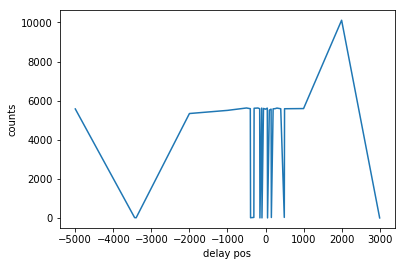

In [111]:
centers = np.sort(np.unique(np.round(pos,decimals=3),axis=None)).flatten()
centerspos = centers
plt.plot(-2*(centers-56.35) / (3e-4), counts)
plt.xlabel('delay pos')
plt.ylabel('counts')
print( -2*(centers-56.35) / (3e-4) )

# Update cutoff to reflect bad points above

In [118]:
cutoff = 400

Text(0.5,1,'I - I(goose)')

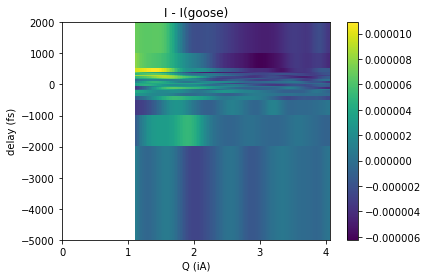

In [119]:
plot2d= (radialAvg)[counts>cutoff,:] #/avgAll

rcent = centers[counts>cutoff]
subAll = np.mean( plot2d[-3:,:][:,:], 0 )
# subAll = np.mean( plot2d[:,:], 0 )
# subAll = np.mean(((offRois.T)/(roio.T)).T,0)
avgAll = np.mean(((offRois.T)/(roio.T)).T,0)
# plot2d = (plot2d-subAll) /avgAll

gf = lambda x: gaussian_filter1d(x,8,axis=-1)
plot2d = (gf(plot2d)-gf(subAll)) #/ gf(avgAll)
# plot2d = gaussian_filter1d(plot2d,2,axis=-1)


dv = .3
# dv = .003
# dv = .001
# qs = x/ 31578.94736842 * 3.5
plt.pcolormesh(Q, -2*(rcent-56.35) / (3e-4) , plot2d)#, vmin = -dv, vmax = dv )
plt.colorbar()

plt.xlabel('Q (iA)')
plt.ylabel('delay (fs)')
plt.title('I - I(goose)')

# Plot integrated regions versus delay

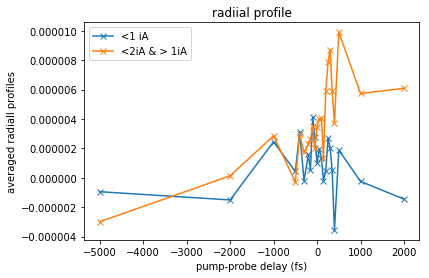

In [121]:
Qrange1 = (Q>1.7)&(Q<2.5)
Qrange2 = (Q>1.2)&(Q<1.7)
Qrange3 = (Q>2)&(Q<2.8)
Qrange4 = (Q>3)&(Q<4)
range1 = np.nanmean( plot2d[:,Qrange1],1 )
range2 = np.nanmean( plot2d[:,Qrange2],1 )
range3 = np.nanmean( plot2d[:,Qrange3],1 )
range4 = np.nanmean( plot2d[:,Qrange4],1 )
# plt.scatter(rcent,range1)
# plt.scatter(rcent,range2)
plt.plot( -2*(rcent-56.35) / (3e-4),range1,'-x',label='<1 iA')
plt.plot( -2*(rcent-56.35) / (3e-4),range2,'-x',label='<2iA & > 1iA')
# plt.ylim([-.0015,.001])
# plt.xlim([-1000,1000])
plt.ylabel('averaged radiall profiles')
plt.xlabel('pump-probe delay (fs)')
plt.title('radiial profile')
plt.legend()

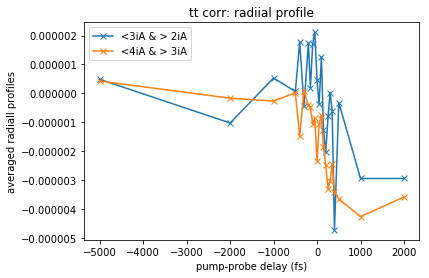

In [123]:

plt.plot(-2*(rcent-56.35) / (3e-4),range3,'-x',label='<3iA & > 2iA')
plt.plot(-2*(rcent-56.35) / (3e-4),range4,'-x',label='<4iA & > 3iA')
# plt.ylim([-.0003,.0003])
plt.ylabel('averaged radiall profiles')
plt.xlabel('pump-probe delay (fs)')
plt.title('tt corr: radiial profile')
plt.legend()

# Repeat with timetool correction

Specify the centers you'd like to use for timetool bining

Histogram shows the number of counts in each bin you'll generate

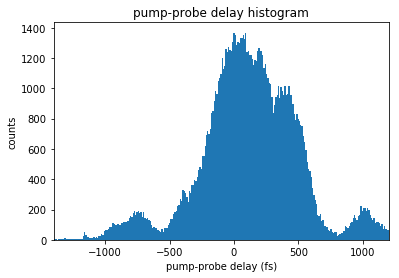

In [137]:
ttpoly = [2.95684259e-06, -1.43969413e-03]
def ttcorr(ttpos,ttpoly):
    return ttpoly[0]*ttpos+ttpoly[1]

truepos = -2*(pos-56.35) / (3e-4)  + ttcorr(ttpos,ttpoly)*1.0e6 # correct
# truepos = -2*(pos-56.35) / (3e-4)  - ttcorr(ttpos,ttpoly)*1.0e6 # wrong
posfs = -2*(pos-56.35) / (3e-4) 

plt.hist(truepos,bins=1000);
plt.xlabel('pump-probe delay (fs)')
plt.ylabel('counts')
# plt.xlim([-10000,10000])
plt.xlim([-1400,1200])
plt.title('pump-probe delay histogram')

usecenters = np.array([3000,2000])
usecenters =  np.append(usecenters,np.arange(1200,-1400,-100))
usecenters = np.append(usecenters,np.array([-2500]))


In [138]:
db = 1e-3
bins = np.unique(pos) - db
bins = np.append(bins, bins[-1]+ 2*db)
nb = bins.size
nr = goodRois.shape[1]

def createBinsFromCenters(centers):
    bins = []
    nc = centers.size
    for idx,c in enumerate(centers):
        if idx == 0:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c-dc)
            bins.append(c+dc)
        elif idx == nc-1:
            dc = np.abs( c - centers[idx-1])/2.
            bins.append(c+dc)
        else:
            dc = np.abs( c - centers[idx+1])/2.
            bins.append(c+dc)
#         print(dc)
    return np.array(bins)

def determineGoodCenters( pos ):
    upos = np.unique(pos)
    gpos = []
    for idx,up in enumerate(upos):
        c = np.sum(upos == up)
        if c>10:
            gpos.append()
        
# bins = np.flip(-2*(createBinsFromCenters(  np.round(usecenters,decimals=2) )-56.35)/(3.0e-4))
# centersfs = np.flip(-2*(np.round(usecenters,decimals=2)-56.35)/(3.0e-4))

bins = createBinsFromCenters( np.flip(np.array(usecenters) ))
centersfs =np.flip(np.array(usecenters))

#### use rough times
# bins = np.flip(-2*(binspos-56.35)/(3.0e-4))
# centersfs = -2*(centerspos-56.35)/(3.0e-4)

# print(bins)
# -(pos-56.35) / (3e-4) 
nb=bins.size
# weightMe = ((goodRois.T)/(roi1.T)).T
print(weightMe.shape, truepos.shape)

radialHist = np.zeros((nb-1,nr))
radialAvg = np.zeros((nb-1,nr))
counts,edges = np.histogram( truepos,bins=bins)
for ir in range(nr):

    radialHist[:,ir],edges = np.histogram( truepos,bins=bins, weights=weightMe[:,ir])
    radialAvg[:,ir] = radialHist[:,ir] / counts
    
# print(counts)

((127319, 200), (127319,))


19
19


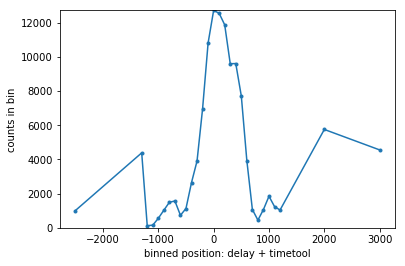

In [139]:
cutoff = 1
plt.plot(centersfs, counts,'.-')
# print(centersfs).-
plt.ylim([cutoff,np.max(counts)])
plt.xlabel('binned position: delay + timetool')
plt.ylabel('counts in bin')
print(np.sum( counts[(centersfs>-1000)&(centersfs<1000)]>cutoff ))
print(( counts[(centersfs>-1000)&(centersfs<1000)].size ))

Text(0.5,1,'ttcorr: (I - I(early))/I(early) ')

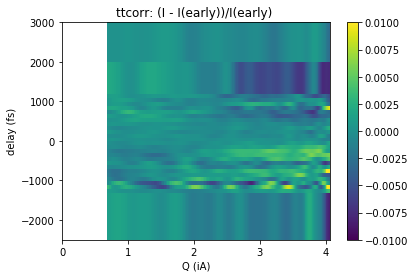

In [140]:


plot2d= (radialAvg)[counts>cutoff,:] #/avgAll
rcent=centersfs[counts>cutoff]
# subAll = np.mean( plot2d[:3,:], 0 )
# subAll = np.mean( plot2d[:,:], 0 )
avgAll = np.mean(((offRois.T)/(roio.T)).T,0)
subAll = np.mean(((offRois.T)/(roio.T)).T,0)
# plot2d = (plot2d-subAll) #/avgAll
# dv = .0001
# plot2d = (plot2d-subAll) /avgAll

gf = lambda x: gaussian_filter1d(x,4,axis=-1)
plot2d = (gf(plot2d)-gf(subAll)) /gf(avgAll)
# plot2d = gaussian_filter1d(plot2d,2,axis=-1)

dv = .01
# dv = .003
# dv = .01
# qs = x/ 31578.94736842 * 3.5
plt.pcolormesh(Q, rcent, plot2d, vmin = -dv, vmax = dv )
plt.colorbar()
plt.xlabel('Q (iA)')
plt.ylabel('delay (fs)')
plt.title('ttcorr: (I - I(early))/I(early) ')
# plt.title('I - I(goose)  for runs'+str(runNumber))
# plt.ylim([0,1100])
# print(x)

# Look at lineouts

NameError: name 'runNumbers' is not defined

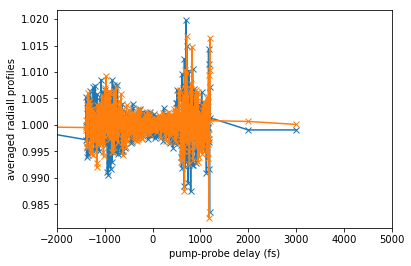

In [128]:
# rcent, plot2d
# print(plot2d.shape)

# Qrange1 = (Q>.6)&(Q<1.5)
# Qrange1 = (Q>.7)&(Q<1.2)
Qrange1 = (Q>1.8)&(Q<2.2)
# Qrange2 = (Q>1.5)&(Q<3.)
Qrange2 = (Q>1.3)&(Q<1.7)
Qrange3 = (Q>2)&(Q<2.8)
Qrange4 = (Q>3)&(Q<4)
# range1 = np.nanmedian( plot2d[:,Qrange1],1 )
# range2 = np.nanmedian( plot2d[:,Qrange2],1 )
# range3 = np.nanmedian( plot2d[:,Qrange3],1 )
# range4 = np.nanmedian( plot2d[:,Qrange4],1 )
range1 = np.nanmean( plot2d[:,Qrange1],1 )
range2 = np.nanmean( plot2d[:,Qrange2],1 )
range3 = np.nanmean( plot2d[:,Qrange3],1 )
range4 = np.nanmean( plot2d[:,Qrange4],1 )

# plt.scatter(rcent,range1)
# plt.scatter(rcent,range2)
plt.plot(rcent,range1,'-x',label='>1.8iA & <2.2iA - antinode')
plt.plot(rcent,range2,'-x',label='<1.7iA & > 1.3iA - node')
# plt.plot(rcent,(range3-range2)/(range2+range3) )
# plt.plot(rcent,range3,'-x',label='<3iA & > 2iA')
# plt.plot(rcent,range4,'-x',label='<4iA & > 3iA')
# plt.ylim([-.0002,.0002])
# plt.xlim([-1000,1000])
# plt.xlim([-1000,2000])
plt.xlim([-2000,5000])
# plt.xlim([-400,1000])
plt.ylabel('averaged radiall profiles')
plt.xlabel('pump-probe delay (fs)')
plt.title('tt corr: radiial profile fors runs '+str(runNumbers))
plt.legend()
plt.xlim([100,1300])
# plt.plot(rcent,range3)
# plt.plot(rcent,range4)


In [55]:
# ridx=(rcent>-1000)&(rcent<=1000)
ridx=(rcent>450)&(rcent<=1000)
fft1 = np.fft.fftshift(np.fft.fft( range1[ridx] - np.mean(range1[ridx]) ))
fft2 = np.fft.fftshift(np.fft.fft(range2[ridx] - np.mean(range2[ridx])))

for2dfft =plot2d[ridx,:]
for2dfft = for2dfft - np.mean(for2dfft,0)
fftall = np.fft.fftshift(np.fft.fft(for2dfft , axis=0 ),axes=(0,))

In [56]:
2*np.pi/(10./1000.)

628.3185307179587

[5]


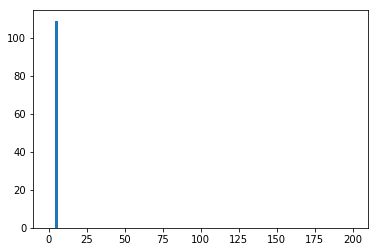

In [57]:
plt.hist(np.diff(rcent[ridx]),bins=100,range=(0,200));
print(np.unique(np.diff(rcent[ridx])))

Text(0.5,1,'thresholded, correct tt: FT(dI/I) for runs [54, 55, 50]')

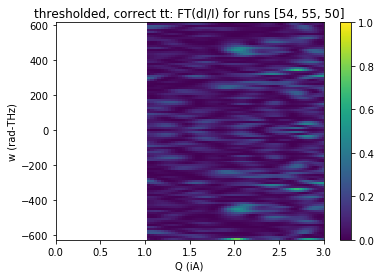

In [62]:
ws = np.fft.fftshift(np.fft.fftfreq(n=fft1.size,d=.005))*2*np.pi
dw = ws[2]-ws[1]
# plt.pcolormesh(Q,ws,np.abs(fftall/dw)**2,vmin=0,vmax=0.5e-4)

# plt.pcolormesh(Q,ws,np.abs(fftall/dw)**2,vmin=0e-3,vmax=.25e-4)
# plt.pcolormesh(Q,ws-dw/2.,np.abs(fftall*dw)**2,vmin=0e-3,vmax=1e1)

dfi=1.
gff = lambda x: gaussian_filter1d(np.real(x),dfi,axis=0)+1.0j*gaussian_filter1d(np.imag(x),dfi,axis=0)
fftfilt = gff(fftall)
plt.pcolormesh(Q,ws,np.abs(fftfilt*dw)**2,vmin=0e-3,vmax=1e0)

# plt.pcolormesh(Q,ws,np.abs(fftall/dw)**2,vmin=.1e-3,vmax=2.5e-3)
# plt.plot(Q,Q,'r')
# plt.plot([1,4.5],np.array([1,1])*2*np.pi/(50./1000.),'r')
# plt.pcolormesh(np.real(fftall),vmin=-.005,vmax=.005)
plt.colorbar()
# plt.ylim([-600,600])
# plt.ylim([-300,300])
# plt.ylim([-100,100])
# plt.ylim([-160,160])
plt.xlim([0,3.])
plt.xlabel('Q (iA)')
plt.ylabel('w (rad-THz)')
plt.title('thresholded, correct tt: FT(dI/I) for runs '+str(runNumbers))

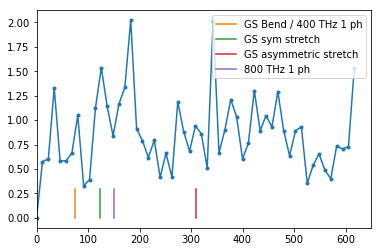

In [59]:
# plt.plot(ws, np.nanmean(np.abs(fftall[:,(Q<4.)&(Q>1.5)]*dw)**2,-1),'.-'  )
# plt.plot(ws, np.nanmean(np.abs(fftall[:,(Q<3)&(Q>2.5)]*dw)**2,-1),'.-'  )
plt.plot(ws, np.nanmean(np.abs(fftall[:,(Q<3)&(Q>1.)]*dw)**2,-1),'.-'  )
plt.xlim([0,650])

lineH = .3
wb=75
plt.plot([wb,wb],[0,lineH],label='GS Bend / 400 THz 1 ph')
# plt.plot([wb/2.,wb/2.],[0,.01])

wss=124
plt.plot([wss,wss],[0,lineH],label='GS sym stretch')
# plt.plot([wss/2.,wss/2.],[0,.01])

# was=289
was=310
plt.plot([was,was],[0,lineH],label='GS asymmetric stretch')
# plt.plot([was/2.,was/2.],[0,.01])

# wr1=75


wr2=150
plt.plot([wr2,wr2],[0,lineH],label='800 THz 1 ph')

plt.legend()

# print(np.mean(np.abs(fftall/dw)**2,-1))

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


(1, 4)

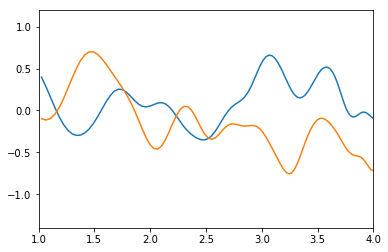

In [60]:
wb = 76
dwb = 10
plt.plot(Q, np.nanmean(np.real(fftall[(ws<wb+dwb)&(ws>wb-dwb),:]*dw),0))
plt.plot(Q, np.nanmean(np.imag(fftall[(ws<wb+dwb)&(ws>wb-dwb),:]*dw),0))
plt.xlim(1,4)

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


(0, 0.3)

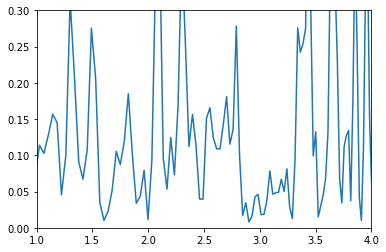

In [78]:
dwss = 4
plt.plot(Q, np.nanmean(np.abs(fftall[(ws<wss+dwss)&(ws>wss-dwss),:]*dw)**2,0))
plt.xlim(1,4)
plt.ylim([0,0.3])

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


(0, 0.16)

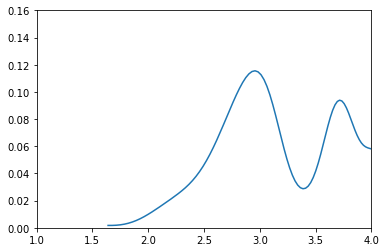

In [54]:
was = 310
dwas = 4
plt.plot(Q, np.nanmean(np.abs(fftall[(ws<was+dwas)&(ws>was-dwas),:]*dw)**2,0))
plt.xlim(1,4)
plt.ylim([0,0.16])

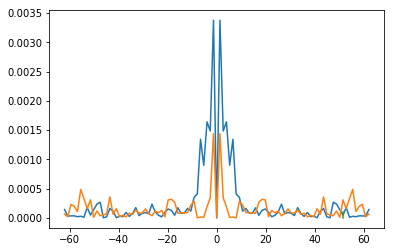

In [240]:
ws = np.fft.fftshift(np.fft.fftfreq(n=fft1.size,d=.05))*2*np.pi
# ws = 2*np.arange(fft1.size)*np.pi/(10./1000.)/fft1.size
ws = ws - np.mean(ws)
plt.plot(ws,np.abs(fft1)**2)
plt.plot(ws,np.abs(fft2)**2)
# plt.plot(ws,np.real(fft1))
# plt.plot(ws,np.real(fft2))
w = np.pi/(61./1000.)
plt.plot([w,w],[0,1e-4])
# plt.xlim([-100,100])
# plt.plot(ws,np.abs(fft2))

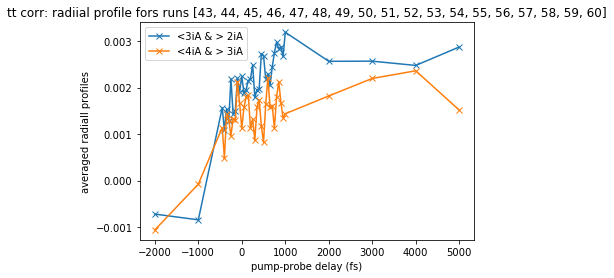

In [1387]:
plt.plot(rcent,range3,'-x',label='<3iA & > 2iA')
plt.plot(rcent,range4,'-x',label='<4iA & > 3iA')
# plt.ylim([-.0001,.0003])
# plt.xlim([-1000,1000])
plt.ylabel('averaged radiall profiles')
plt.xlabel('pump-probe delay (fs)')
plt.title('tt corr: radiial profile fors runs '+str(runNumbers))
plt.legend()
# plt.xlim([-500,500])
# plt.plot(rcent,range3)
# plt.plot(rcent,range4)
